# Multithreading

## What are threads?
Threads are execution units within a process that can run simultaneously.

<img src="./imgs/what-are-threads.png" width=500px>

While processes are entirely separate, threads run in a **shared memory** space (heap).

## Starting Julia with multiple threads

By default, Julia starts with a single *user thread*. We must tell it explicitly to start multiple user threads. There are two ways to do this:

* Environment variable: `JULIA_NUM_THREADS=4`
* Command line argument: `julia -t 4`

**Jupyter lab:**

The simplest way is to globally set the environment variable `JULIA_NUM_THREADS` (e.g. in the `.bashrc`). But one can also create a specific Jupyter kernel for multithreaded Julia:

```julia
using IJulia
installkernel("Julia (4 threads)", env=Dict("JULIA_NUM_THREADS"=>"4"))
```

We can readily check how many threads we are running:

In [1]:
Threads.nthreads()

6

**It is currently not (easily) possible to change the number of threads at runtime!** (Will likely change in the future.)

### User threads vs default threads

Technically, the Julia process is also spawning multiple threads already in "single-threaded" mode, like
* a thread for unix signal listening
* multiple OpenBLAS threads for BLAS/LAPACK operations

For this reason, we call the threads specified via `-t` or the environment variable *user threads* or simply *Julia threads*.

## Tasks

By default, Julia waits for commands to finish ("**blocking**") and runs everything sequentially.

**Tasks** are a feature that allows (parts of) computations to be scheduled (suspended and resumed) in a flexible manner to implement **concurrency** (multitasking) and **parallelism**.

* Concurrency is about dealing with lots of things at once.
* Parallelism is about doing lots of things at once .

Example (concurrency): **asynchronous I/O** like
 * **multiple user input** (Why not already process some of the input?)
 * **data dumping to disk** (Maybe it's possible to continue a calculation?)
 * **receiving calculations from worker processes**
 
Example (parallelism): **multithreading, distributed computing**

## `@async` and `@sync`

We can create a task for asynchronous execution with the [`@async` macro](https://docs.julialang.org/en/v1/base/parallel/#Base.@async). What this means is that for whatever falls into its scope, Julia will start a task to then proceed to whatever comes next in the script without waiting for the task to complete ("**non-blocking**").

(**Note:** `@async` is kind of deprecated in favor of `@spawn` below, but we quickly mention it here nonetheless for pedagogical reasons)

In [2]:
@time sleep(2);

  2.004023 seconds (66 allocations: 1.688 KiB)


In [3]:
@time @async sleep(2)

  0.010239 seconds (10.25 k allocations: 653.394 KiB, 47.61% compilation time)


Task (runnable) @0x0000000110328970

Julia allows the script to proceed (and the `@time` macro to fully execute) without waiting for the task (in this case, sleeping for two seconds) to complete.

We can use the partner macro `@sync` to synchronize, that is wait for all encapsulated tasks. (see `?@sync`). 

In [4]:
@time @sync @async sleep(2)

  2.016832 seconds (8.27 k allocations: 563.566 KiB, 0.71% compilation time)


Task (done) @0x00000001606ced60

Of course, here it doesn't make much sense to write `@sync @async` - we could simply drop it altogether. A better example is the following.

In [5]:
@time @sync begin
    @async sleep(2.0)
    @async sleep(2.0)
end

  2.014300 seconds (15.93 k allocations: 1.073 MiB, 0.58% compilation time)


Task (done) @0x00000001607ae8b0

In [6]:
A = rand(1000,1000)
B = rand(1000,1000)

t = @async A * B

Task (done) @0x000000010cf3c970

In [7]:
wait(t)

In [8]:
fetch(t)

1000×1000 Matrix{Float64}:
 268.879  259.798  250.878  266.512  …  270.602  262.027  261.164  253.96
 252.857  242.812  242.074  249.457     245.117  242.803  238.848  235.687
 246.945  236.736  239.504  251.309     251.134  244.448  237.704  233.044
 258.244  252.089  245.734  255.452     257.442  257.832  247.737  246.051
 249.679  243.525  239.285  253.128     251.17   246.335  239.088  234.216
 246.626  241.637  236.059  253.386  …  246.628  244.399  234.225  237.769
 258.485  247.523  246.069  260.845     257.863  254.076  247.922  244.156
 260.396  255.121  258.023  262.752     264.713  262.819  252.783  254.63
 258.323  246.18   243.245  257.751     260.368  257.185  243.52   246.822
 248.838  238.733  242.413  248.651     250.756  246.208  241.042  237.647
 256.611  249.556  245.223  259.049  …  250.029  251.825  242.895  240.76
 254.473  249.277  245.88   254.704     253.815  253.671  245.242  244.098
 259.916  250.889  245.537  260.273     263.376  257.854  246.965  244.587
 

## Task-based multithreading

In traditional HPC, we typically care about threads directly. Using e.g. OpenMP, we essentially tell each thread what to do.

Conceptually, Julia takes a different approach and implements **task-based** multithreading. In this paradigm, a task - e.g. a computational piece of a code - is marked for **parallel** execution on **any** of the available Julia threads. Julias **dynamic scheduler** will automatically put the task on one of the threads and trigger the execution of the task on said thread.

**Users should think about tasks and not threads**.

<br>
<img src="./imgs/task-based-parallelism.png" width=250px>
<br>

**Advantages:**
* high-level abstraction
* **composability / nestability** (Multithreaded code can call multithreaded code can call multithreaded code ....)

**Disadvantages:**
* potential scheduling overhead
* task → thread assignment uncertain (can vary dynamically + task migration)
* **can get in the way when performance engineering**
  * scheduler has limited information (e.g. about the system topology)
  * low-level profiling (e.g. with LIKWID) requires fixed `task -> thread -> core` mapping.

### Spawning tasks on threads: `Threads.@spawn`
`Threads.@spawn` spawns a task on a Julia thread. Specifically, it creates (and immediately returns) a `Task` and schedules it for execution on an available Julia thread.

To avoid having to prefix `Threads.` to `@spawn` (and other threading-related functions) let's load everything from `Base.Threads` into global scope.

In [1]:
using Base.Threads

In [10]:
@spawn println("test")

test


Task (done) @0x000000011018c7e0

While `Threads.@spawn` returns the task right away - it is **non-blocking** - the result might only be fetchable after some time.

In [11]:
t = @spawn begin
    sleep(3);
    "result"
end
@time fetch(t)

  2.993763 seconds (93 allocations: 2.781 KiB)


"result"

Note that we can use (some of) the control flow tools that we've already covered, like `@sync`.

In [12]:
@sync t = @spawn begin
    sleep(3);
    "result"
end
@time fetch(t)

  0.000004 seconds


"result"

In [13]:
for i in 1:2*nthreads()
    @spawn println("Hi, I'm ", threadid())
end

Hi, I'm 2
Hi, I'm 4
Hi, I'm 1
Hi, I'm 4
Hi, I'm 4
Hi, I'm 6
Hi, I'm 4
Hi, I'm 4
Hi, I'm 5
Hi, I'm 4
Hi, I'm 4
Hi, I'm 3


#### Example: Recursive Fibonacci series

$$ F(n) = F(n-1) + F(n-2), \qquad F(1) = F(2) = 1$$

We can nest `@spawn` calls freely!

In [14]:
function fib(n)
    n < 2 && return n
    t = @spawn fib(n-2)
    return fib(n-1) + fetch(t)
end

fib (generic function with 1 method)

In [15]:
fib.(1:10)

10-element Vector{Int64}:
  1
  1
  2
  3
  5
  8
 13
 21
 34
 55

(Note: Algorithmically, this is a highly inefficient implementation of the Fibonacci series, of course!)

#### Example: `tmap` (threaded `map`)

(again, not the most efficient implementation but fine for now)

In [16]:
tmap(fn, itr) = map(fetch, map(i -> Threads.@spawn(fn(i)), itr))

tmap (generic function with 1 method)

In [17]:
using LinearAlgebra

In [18]:
M = [rand(200,200) for i in 1:10];

In [19]:
tmap(svdvals, M)

10-element Vector{Vector{Float64}}:
 [100.20264877172369, 8.082093041904395, 8.021738855108818, 7.790155548805853, 7.665604414319819, 7.562567054702036, 7.527574580093636, 7.383020948498931, 7.2777684885435185, 7.221973423117439  …  0.31736683504071245, 0.28777172410456753, 0.24981408651342543, 0.1804980495804018, 0.1509651839840443, 0.11935322929094451, 0.10305093633625538, 0.05696249933781086, 0.05326198479664796, 0.023560582289144472]
 [100.3808162657498, 7.895138959496896, 7.8252953138049826, 7.798553623175687, 7.685565407604833, 7.62979301785614, 7.51826089179633, 7.435406637466756, 7.3027857978983715, 7.274114477185104  …  0.2624183065450126, 0.25147395247228377, 0.22561901286414252, 0.17856098272223941, 0.15032076617386883, 0.1052138873592595, 0.06572823955340538, 0.0421514761206359, 0.0378789378490256, 0.010196888973164881]
 [100.05489955237096, 7.957118559309348, 7.808878625965481, 7.725566233083042, 7.599709323885147, 7.537258733249621, 7.408749561528617, 7.369067256959165, 7

In [20]:
tmap(i -> println(i, " ($(threadid()))"), 1:10);

4 (4)
5 (4)
7 (6)
6 (4)
9 (1)
10 (4)
8 (4)
2 (2)
3 (5)
1 (3)


Note, however, that this implementation creates temporary allocations and thus isn't particularly efficient.

In [21]:
using BenchmarkTools

@btime tmap($svdvals, $M);
@btime map($svdvals, $M);

  17.361 ms (148 allocations: 4.22 MiB)
  34.524 ms (81 allocations: 4.22 MiB)


### Multithreading for-loops: `@threads`

In [22]:
@threads for i in 1:2*nthreads()
    println("Hi, I'm ", threadid())
end

Hi, I'm 1
Hi, I'm 2
Hi, I'm 3
Hi, I'm 2
Hi, I'm 4
Hi, I'm 4
Hi, I'm 2
Hi, I'm 6
Hi, I'm 2
Hi, I'm 4
Hi, I'm 5
Hi, I'm 5


By default, `@threads` creates `nthreads()` many tasks each processing a contigious region of the iteration space. Each task is then essentially spawned with `@spawn`.

In [2]:
using BenchmarkTools

function square!(x)
    for i in eachindex(x)
        x[i] = x[i]^2
    end
end

function square_threads!(x)
    @threads for i in eachindex(x)
        x[i] = x[i]^2
    end
end

square_threads! (generic function with 1 method)

In [3]:
x = rand(1_000_000)
@btime square!($x);
@btime square_threads!($x);

  145.292 μs (0 allocations: 0 bytes)
  60.167 μs (34 allocations: 3.25 KiB)


#### Nestability / Composability

Multithreaded loops can be nested! → composability

In [28]:
function square_threads_all!(xs)
    @threads for i in eachindex(xs)
        square_threads!(xs[i])
    end
end
function square_all!(xs)
    @threads for i in eachindex(xs)
        square!(xs[i])
    end
end

square_all! (generic function with 1 method)

In [31]:
xs = [rand(n,n) for n in (100,1000,10_000)]

@btime square_threads_all!($xs) samples = 5 evals = 3
@btime square_all!($xs) samples = 5 evals = 3

  28.208 ms (135 allocations: 12.98 KiB)
  41.340 ms (35 allocations: 3.28 KiB)


### Task-based vs thread-based multithreading

If one is coming from an OpenMP background (or similar), it is very easy to not forget about the task-based nature of Julia's multithreading. This might even be reinforced by names like `@threads` and the existence of functions like `threadid()`. Unfortunately, this can readily lead to incorrect code.

#### Task migration and `threadid()`

Since the user should conceptually only care about tasks, Julia's scheduler isn't only dynamically assigning tasks to any of the Julia threads, but it is also free to **migrate tasks between threads**. For example, a task might start running on Julia thread 1, then be paused and moved to Julia thread 3, where it then finishes execution. Hence, by default, there is **no fixed task-thread mapping**.

→ **`threadid()` should be used with extreme care** as its output isn't guaranteed to be constant across the exectution of a task!

### Unsafe (!) example: partial sums

In [32]:
function partial_sums_unsafe(data)
    psums = zeros(nthreads())
    @threads for x in data
        tid = threadid()
        old_sum = psums[tid]
        # do_something()
        new_sum = old_sum + x
        psums[tid] = new_sum
    end
    return psums
end

partial_sums_unsafe (generic function with 1 method)

Why is this conceptually unsafe?

Note that while semantically unsafe, the function above might still work fine in practice. This is because task migration is (at least as of now) very rare. (The scheduler isn't using the freedom much.)

In [71]:
data = rand(1_000 * nthreads());

In [76]:
sum(partial_sums_unsafe(data)) ≈ sum(data) # very likely still gives true

true

##### Fix 1: Iterate over indices instead of data

**Idea:** Partition the data into chunks and then iterate over chunk indices instead of the data itself. In each iteration (task) one chunk is processed. (Below the number of chunks is chosen as `nthreads()`.)

In [91]:
function partial_sums_safe1(data)
    psums = zeros(nthreads())
    
     # manual partitioning of data
    data_chunks = collect(Iterators.partition(data, length(data)÷nthreads()))
    
    @threads for tid in 1:nthreads() # iterate over thread ids
        for x in data_chunks[tid] # iterate over data chunk
            old_sum = psums[tid]
            new_sum = old_sum + x
            psums[tid] = new_sum
        end
    end
    return psums
end

partial_sums_safe1 (generic function with 1 method)

**Note:** The **iteration variable** is always constant across one iteration.

In [92]:
sum(partial_sums_safe1(data)) ≈ sum(data)

true

The package [ChunkSplitters.jl](https://github.com/m3g/ChunkSplitters.jl) simplifies this pattern of manual chunking.

In [114]:
using ChunkSplitters

In [115]:
collect(chunks(data, nthreads()))

6-element Vector{Tuple{UnitRange{Int64}, Int64}}:
 (1:1000, 1)
 (1001:2000, 2)
 (2001:3000, 3)
 (3001:4000, 4)
 (4001:5000, 5)
 (5001:6000, 6)

In [116]:
function partial_sums_safe_chunks(data; nchunks=nthreads())
    psums = zeros(nchunks)
    @threads for (data_range, ichunk) in chunks(data, nchunks)
        for idata in data_range
            old_sum = psums[ichunk]
            new_sum = old_sum + data[idata]
            psums[ichunk] = new_sum
        end
    end
    return psums
end

partial_sums_safe_chunks (generic function with 1 method)

In [117]:
sum(partial_sums_safe_chunks(data)) ≈ sum(data)

true

Note that this chunking scheme also isn't "thread-biased" anymore in the sense that we can choose `nchunks != nthreads()`.

##### Fix 2: Opt-out of task migration (*sticky tasks*)

We can choose the `:static` scheduling option for `@threads` to opt-out of Julia's dynamic scheduling and get **guarantees about the task-thread assignment**. Clean solution for traditional HPC but low-level and non-composable etc.


Syntax: `@threads :static for ...`

 * splits up the iteration space into `nthreads()` even, contiguous blocks (in-order) and creates precisely one task per block
 * **statically** maps tasks to threads, specifically: task 1 -> thread 1, task 2 -> thread 2, etc.
   * -> no task migration, i.e. **fixed task-thread mapping** 👍
   * -> only little overhead 👍
   * -> not composable / nestable 👎
     

In [38]:
@threads :dynamic for i in 1:2*nthreads()
    println(i, " -> thread ", threadid())
end

7 -> thread 2
3 -> thread 6
5 -> thread 1
4 -> thread 6
8 -> thread 2
11 -> thread 4
6 -> thread 4
12 -> thread 2
1 -> thread 5
2 -> thread 6
9 -> thread 3
10 -> thread 3


In [39]:
@threads :static for i in 1:2*nthreads()
    println(i, " -> thread ", threadid())
end

5 -> thread 3
3 -> thread 2
11 -> thread 6
4 -> thread 2
9 -> thread 5
7 -> thread 4
1 -> thread 1
10 -> thread 5
8 -> thread 4
12 -> thread 6
2 -> thread 1
6 -> thread 3


For `@threads :static`, every thread handles precisely two iterations!

In [40]:
@threads :dynamic for i in 1:3
    @threads :dynamic for j in 1:3
        println("$i, $j")
    end
end

1, 1
3, 1
1, 2
2, 3
3, 2
2, 2
2, 1
3, 3
1, 3


In [41]:
@threads :static for i in 1:3
    @threads :static for j in 1:3
        println("$i, $j")
    end
end

LoadError: TaskFailedException

[91m    nested task error: [39m`@threads :static` cannot be used concurrently or nested
    Stacktrace:
     [1] [0m[1merror[22m[0m[1m([22m[90ms[39m::[0mString[0m[1m)[22m
    [90m   @[39m [90mBase[39m [90m./[39m[90m[4merror.jl:35[24m[39m
     [2] [0m[1mmacro expansion[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:207[24m[39m[90m [inlined][39m
     [3] [0m[1mmacro expansion[22m
    [90m   @[39m [90m./[39m[90m[4mIn[41]:2[24m[39m[90m [inlined][39m
     [4] [0m[1m(::var"#400#threadsfor_fun#108"{var"#400#threadsfor_fun#106#109"{UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:200[24m[39m
     [5] [0m[1m#400#threadsfor_fun[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:167[24m[39m[90m [inlined][39m
     [6] [0m[1m(::Base.Threads.var"#1#2"{var"#400#threadsfor_fun#108"{var"#400#threadsfor_fun#106#109"{UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:139[24m[39m

...and 2 more exceptions.


**Note about `@spawn`**: we can also opt-out of task migration for `@spawn` and **spawn *sticky* tasks on specific threads**. However, Julia doesn't have a built-in tool for this (as of now) and one needs to use a package like, e.g., [ThreadPinning.jl](https://github.com/carstenbauer/ThreadPinning.jl). The latter exports a function `@tspawnat <threadid> ...`.

In [46]:
using ThreadPinning

@tspawnat 2 println("running on thread ", threadid())

Task (runnable) @0x00000001127753c0

running on thread 2


### Load-balancing

If there are many tasks (e.g. many more than there are threads), Julia's scheduler balances the load of these tasks among threads. This can be utilized for non-uniform workloads with `@spawn` (and `@sync`).

In [106]:
function compute_nonuniform_spawn!(a, niter = zeros(Int, nthreads()), load = zeros(Int, nthreads()))
    @sync for i in 1:length(a)
        Threads.@spawn begin
            a[i] = sum(abs2, rand() for j in 1:i)
            
            # poor-mans bookkeeping (unsafe! we're assuming/hoping that tasks don't migrate 😄)
            niter[threadid()] += 1
            load[threadid()] += i
        end
    end
    return niter, load
end

compute_nonuniform_spawn! (generic function with 3 methods)

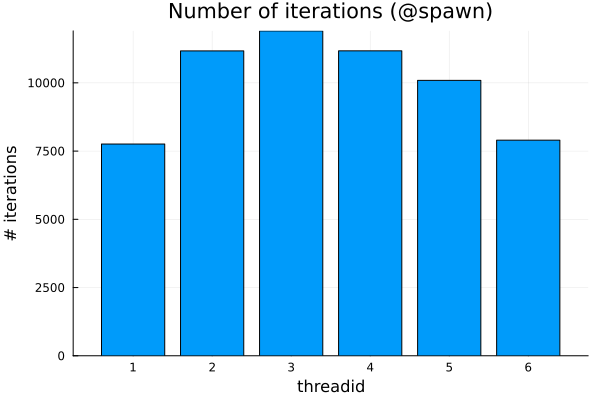

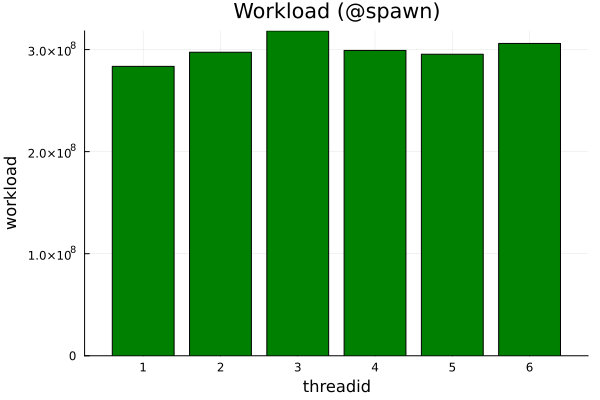

In [118]:
using Plots

a = zeros(nthreads()*10_000)
niter, load = compute_nonuniform_spawn!(a)

b1 = bar(niter, xlab="threadid", ylab="# iterations", title="Number of iterations (@spawn)", legend=false)
b2 = bar(load, xlab="threadid", ylab="workload", title="Workload (@spawn)", legend=false, color=:green)

display(b1)
display(b2)

Compare this to `@threads` which doesn't give load-balancing.

In [110]:
function compute_nonuniform_threads!(a, niter = zeros(Int, nthreads()), load = zeros(Int, nthreads()))
    @threads for i in 1:length(a)
        a[i] = sum(abs2, rand() for j in 1:i)

        # poor-mans bookkeeping (unsafe! we're assuming/hoping that tasks don't migrate 😄)
        niter[threadid()] += 1
        load[threadid()] += i
    end
    return niter, load
end

compute_nonuniform_threads! (generic function with 3 methods)

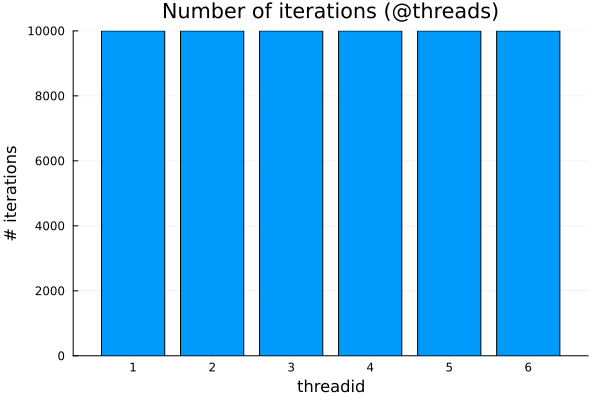

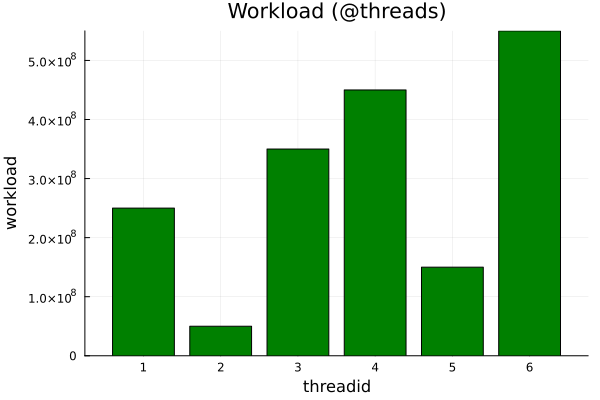

In [116]:
using Plots

a = zeros(nthreads()*10_000)
niter, load = compute_nonuniform_threads!(a)

b1 = bar(niter, xlab="threadid", ylab="# iterations", title="Number of iterations (@threads)", legend=false)
b2 = bar(load, xlab="threadid", ylab="workload", title="Workload (@threads)", legend=false, color=:green)

display(b1)
display(b2)

(There might be a scheduling option for `@threads` that implements load-balancing in the future.)

## Multithreading: Things to be aware of

### Race conditions and thread safety

In [ ]:
function sum_serial(x)
    s = zero(eltype(x))
    for i in eachindex(x)
        @inbounds s += x[i]
    end
    return s
end

In [ ]:
function sum_threads_naive(x)
    s = zero(eltype(x))
    @threads for i in eachindex(x)
        @inbounds s += x[i]
    end
    return s
end

In [47]:
numbers = rand(nthreads()*10_000);

In [ ]:
@show sum(numbers);
@show sum_serial(numbers);
@show sum_threads_naive(numbers);

**Wrong** result! Even worse, it's **non-deterministic** and different every time! It's also slow...

In [ ]:
@btime sum_serial($numbers);
@btime sum_threads_naive($numbers);

Reason: There is a [race condition](https://en.wikipedia.org/wiki/Race_condition).

Note that race conditions aren't specific to reductions. More generally, they can appear when multiple threads are modifying a shared "global" state simultaneously.

Not all of Julia and its packages in the ecosystem are thread-safe! In general, it is safer to assume that they're not unless documented/proven otherwise.

#### Fix 1: Divide the work

In [ ]:
function sum_threads_subsums(x)
    blocksize = length(x) ÷ nthreads()
    @assert isinteger(blocksize)
    idcs = collect(Iterators.partition(1:length(x), blocksize))
    
    subsums = zeros(eltype(x), nthreads())
    @threads for tid in 1:nthreads()
        for i in idcs[tid]
            @inbounds subsums[tid] += x[i]
        end
    end
    return sum(subsums)
end

In [ ]:
@show sum(numbers);
@show sum_serial(numbers);
@show sum_threads_subsums(numbers);

In [ ]:
@btime sum_threads_subsums($numbers);

Speedup and correct result. But not ideal:

* more cumbersome
* can have more subtle performance issues like [false sharing](https://en.wikipedia.org/wiki/False_sharing#:~:text=In%20computer%20science%2C%20false%20sharing,managed%20by%20the%20caching%20mechanism.)

#### Fix 2: Atomics

See [Atomic Operations](https://docs.julialang.org/en/v1/manual/multi-threading/#Atomic-Operations) in the Julia doc for more information. But in generaly one shouldn't avoid using them as much as possible since they actually limit the parallelism.

### Garbage collection

[As of now](https://www.youtube.com/watch?v=Ks0p6PQyIPs), **Julia's GC is not parallel** and doesn't work nicely with multithreading. (Update: In Julia 1.10 the GC will be parallel!)

If it gets triggered, it stops the world (all threads) for clearing up memory.

Hence, when using multithreading, it is even more important to **avoid heap allocations!**

(If you can't avoid allocations, consider using multiprocessing instead.)

## High-level tools for parallel computing

### [ThreadsX.jl](https://github.com/tkf/ThreadsX.jl)

*Parallelized Base functions*

In [48]:
using ThreadsX

In [49]:
sum(numbers)

30095.69984107821

In [50]:
ThreadsX.sum(numbers)

30095.69984107821

In [51]:
@btime ThreadsX.sum($numbers);

  26.959 μs (444 allocations: 35.52 KiB)


### [FLoops.jl](https://github.com/JuliaFolds/FLoops.jl)

*Fast sequential, threaded, and distributed for-loops for Julia*

In [52]:
using FLoops

In [53]:
function sum_floops(x)
    @floop for xi in x
        @reduce(s = zero(eltype(x)) + xi)
    end
    return s
end

sum_floops (generic function with 1 method)

In [54]:
@btime sum_floops($numbers);

  20.958 μs (62 allocations: 4.19 KiB)


In [55]:
numbers = rand(nthreads()*10_000);

sum_floops(numbers) ≈ sum(numbers)

true

In [56]:
@btime sum_serial($numbers);
@btime sum_floops($numbers);

LoadError: UndefVarError: `sum_serial` not defined

`@floop` supports different *executors* that allow for easy switching between serial and threaded execution

In [57]:
function sum_floops(x, executor)
    @floop executor for xi in x
        @reduce(s += xi)
    end
    return s
end

sum_floops (generic function with 2 methods)

In [58]:
@btime sum_floops($numbers, $(SequentialEx()));
@btime sum_floops($numbers, $(ThreadedEx()));

  56.041 μs (0 allocations: 0 bytes)
  20.625 μs (55 allocations: 4.08 KiB)


There are many more [executors](https://juliafolds.github.io/FLoops.jl/stable/tutorials/parallel/#tutorials-executor), like `DistributedEx` or `CUDAEx`. See, e.g., [FoldsThreads.jl](https://github.com/JuliaFolds/FoldsThreads.jl) and [FoldsCUDA.jl](https://github.com/JuliaFolds/FoldsCUDA.jl).

Under the hood, FLoops is built on top of [Transducers.jl](https://juliafolds.github.io/Transducers.jl/stable/tutorials/tutorial_parallel/) (i.e. it translates for-loop semantics into folds).

### [Tullio.jl](https://github.com/mcabbott/Tullio.jl)

*Tullio is a very flexible einsum macro* ([Einstein notation](https://en.wikipedia.org/wiki/Einstein_notation))

In [59]:
using Tullio

In [60]:
A = rand(10,10)
B = rand(10,10)

C = @tullio C[i,j] := A[i,k] * B[k,j] # matrix multiplication

C ≈ A * B

true

In [61]:
sum_tullio(xs) = @tullio S := xs[i]

sum_tullio (generic function with 1 method)

In [62]:
@btime sum_tullio($numbers);

  14.458 μs (0 allocations: 0 bytes)


(Uses `fastmath` and other tricks to be faster here.)

### [LoopVectorization.jl](https://github.com/JuliaSIMD/LoopVectorization.jl)

*Macro(s) for vectorizing loops.*

In [63]:
using LoopVectorization

In [64]:
function sum_turbo(x)
    s = zero(eltype(x))
    @tturbo for i in eachindex(x)
        @inbounds s += x[i]
    end
    return s
end

sum_turbo (generic function with 1 method)

In [65]:
@btime sum_turbo($numbers);

  5.576 μs (0 allocations: 0 bytes)


(Uses all kinds of SIMD tricks to be faster than the others.)

## Thread affinity/pinning

A compute node has a complex topology (two sockets, multiple memory channels/domains). **It matters (dramatically) for performance where your Julia threads are running!** → Thread pinning

### Hawk compute node

<img src="./imgs/lstopo_hawk.svg" width=100%>

### Pinning Julia threads to CPU threads/cores

What about external tools like `numactl`, `taskset`, etc.? Doesn't work reliably because they often [can't distinguish](https://discourse.julialang.org/t/thread-affinitization-pinning-julia-threads-to-cores/58069/5) between Julia threads and other internal threads.

**Options:**

* Environment variable: `JULIA_EXCLUSIVE=1` (compact pinning)
* More control and convenient visualization: [ThreadPinning.jl](https://github.com/carstenbauer/ThreadPinning.jl) -> **Exercise saxpy_cpu**

#### [ThreadPinning.jl](https://github.com/carstenbauer/ThreadPinning.jl)

(See my short talk at JuliaCon2023 @ MIT: https://youtu.be/6Whc9XtlCC0)

**Pinning at three conceptual levels**

<br>
<img src="./imgs/threadpinning_pinthreads.svg" width=600px>
<br>

* `:cputhreads:` pin to CPU threads (incl. "hypterthreads") one after another
* `:cores:` pin to CPU cores one after another
* `:numa:` alternate between NUMA domains so, e.g., 0, 16, 32, 48, 64, .... (if a NUMA domain has 16 cores)
* `:sockets:` alternate between sockets so, e.g., 0, 64, 1, 65, 2, 66, .... (if a socket has 64 cores)


**Visualization of cluster topology and thread affinities**

<br>
<img src="./imgs/threadinfo.png" width=1000px>